In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from datetime import datetime, timedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf


In [28]:
end_date = datetime.today()
# start_date = end_date + timedelta(days=-5*365)
start_date = datetime(2010, 1, 1)
nifty = yf.download('^NSEI', start=start_date, end=end_date)
hist_close = nifty['Adj Close']

hist_ret = hist_close.pct_change(1)
hist_ret.dropna(inplace=True)
hist_ret = hist_ret * 100.0
hist_ret

[*********************100%***********************]  1 of 1 completed


Date
2010-01-05    0.873432
2010-01-06    0.073891
2010-01-07   -0.354040
2010-01-08   -0.348656
2010-01-11    0.088658
                ...   
2021-07-26   -0.199291
2021-07-27   -0.492908
2021-07-28   -0.235290
2021-07-29    0.439544
2021-07-30   -0.097604
Name: Adj Close, Length: 2835, dtype: float64

## Gaussian Mixture Model

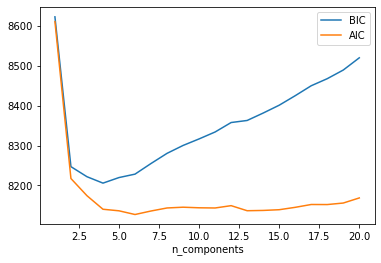

In [8]:
from sklearn.mixture import GaussianMixture

X = hist_ret.values.reshape(-1, 1)

n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

We may choose two or three states based on the AIC graph. Two states could be explained as high and low vol regimes; while three states hopefully can coincide with uptrend, downtrend and sideways.



In [10]:
# Here I choose 2 states
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(X)
labels = gmm.predict(X)

In [11]:
# the result suggests first state is low vol, second state is high vol.
print(gmm.means_, gmm.covariances_)

[[ 0.09358956]
 [-0.05581083]] [[[0.4678281 ]]

 [[2.76384919]]]


In [12]:
gmm.predict_proba(X)


array([[0.75498186, 0.24501814],
       [0.83503692, 0.16496308],
       [0.80550512, 0.19449488],
       ...,
       [0.81896535, 0.18103465],
       [0.82282429, 0.17717571],
       [0.82925731, 0.17074269]])

In [15]:
gmm_regimes = gmm.predict(X)
gmm_regimes

array([0, 0, 0, ..., 0, 0, 0])

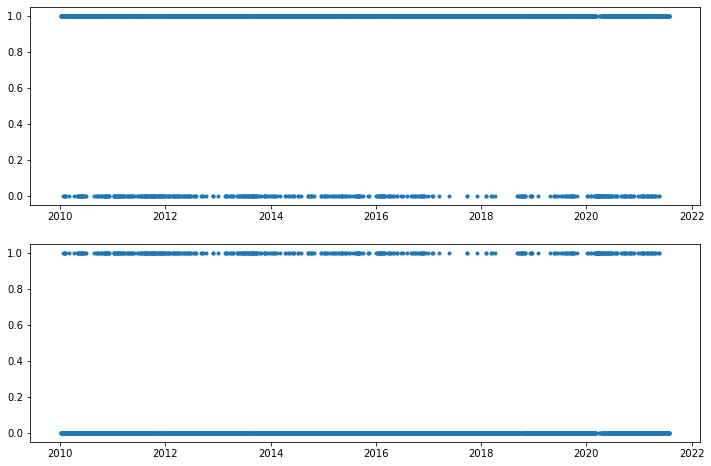

In [16]:
first_state = [1 if r == 0 else 0 for r in gmm_regimes]
second_state = [1 if r == 1 else 0 for r in gmm_regimes]
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].plot(hist_ret.index, first_state, '.', label='first regime')
axes[1].plot(hist_ret.index, second_state, '.', label='second regime')
plt.show()

In [17]:
print(np.sum(first_state), np.sum(second_state), hist_ret.shape[0])


2369 466 2835


## Markov Regime Switch Model

In [18]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression


In [19]:
model = MarkovRegression(hist_ret, k_regimes=2, trend='nc', switching_variance=True)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [20]:
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2835
Model:               MarkovRegression   Log Likelihood               -3998.665
Date:                Sat, 31 Jul 2021   AIC                           8005.330
Time:                        23:59:04   BIC                           8029.129
Sample:                             0   HQIC                          8013.915
                               - 2835                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.6893      0.029     23.699      0.000       0.632       0.746
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.1933      0.437      9.603      0.000       3.337       5.049
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9867      0.004    277.600      0.000       0.980       0.994
p[1->0]        0.0748      0.020      3.793      0.000       0.036       0.113
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

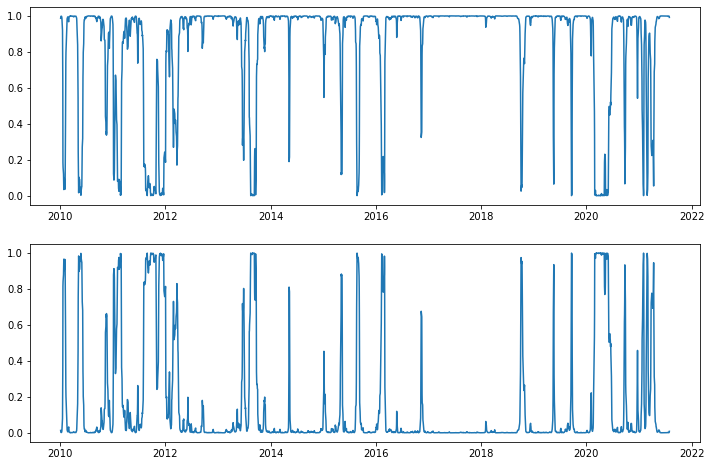

In [21]:
# Regime switch model has better results; which is expected.
# Gaussian mixture doesn't consider time sequence of historical returns.
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].plot(res.smoothed_marginal_probabilities[0], label='first regime')
axes[1].plot(res.smoothed_marginal_probabilities[1], label='second regime')
plt.show()

In [22]:
print(np.sum(res.smoothed_marginal_probabilities[0] > 0.5), np.sum(res.smoothed_marginal_probabilities[1] > 0.5), hist_ret.shape[0])

2438 397 2835


## Evaluation (Comparision with IndiaVIX)

In [29]:
# VIX shadow
vix = yf.download('^INDIAVIX',start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [ ]:
vix

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,8))
ax1.plot(vix['Adj Close'], label='vix', color='blue')
ax2 = ax1.twinx()
ax2.plot(res.smoothed_marginal_probabilities[1], label='second regime', color='lightgreen')
fig.tight_layout()
plt.show()